# Exploring Global Weather Forecasts with BigQuery and WeatherNext 2

**Welcome!** This notebook introduces a weather forecast dataset available in BigQuery, generated by Google DeepMind and Google Research's WeatherNext 2 model. Through a series of sample queries, we'll demonstrate how to access, analyze, and visualize this data to gain insights into global weather patterns, trends, and potential impacts.

**Dataset Overview**

This dataset offers weather forecasts produced by WeatherNext 2, a state-of-the-art machine learning model developed by Google DeepMind and Google Research. It provides predictions for various weather variables, including temperature, precipitation, wind speed, and more, at a global scale and with a high degree of accuracy. Each forecast consists of 64 ensemble members, representing 64 different possible outcomes. The dataset is partitioned by day on the `init_time` column, similar to the structure used by NOAA in their weather data tables.

**Notebook Purpose**

This notebook aims to:

* Familiarize users with the structure and content of the WeatherNext 2 weather forecast dataset in BigQuery.
* Demonstrate how to query and analyze this data using BigQuery's powerful tools and functions.
* Showcase the potential applications of this data for various weather-related tasks, such as forecasting, climate analysis, and risk assessment.

**Copyright Information**

Copyright 2025 Google LLC.

All materials are licensed under the [Creative Commons Attribution 4.0 International License (CC-BY)](https://creativecommons.org/licenses/by/4.0/legalcode).

**Additional Documentation**

[BigQuery Client Library Documentation](https://cloud.google.com/python/docs/reference/bigquery/latest)

## Import Python Libraries & Some Other Setup

In [ ]:
from collections.abc import Mapping

import folium
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

import warnings
# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

## Set Google Cloud/BigQuery Project ID

In [ ]:
project_id = '<project-name>' #@param{type:"string"}

# Weather Forecast Dataset Schema

This describes the schema for a weather forecast dataset.

## Top-level fields

<div align="left">

| Field Name | Type | Mode | Description |
|---|---|---|---|
| `init_time` | TIMESTAMP | NULLABLE | The initialization time of the forecast. |
| `geography` | GEOGRAPHY | NULLABLE | The geographic point location for this forecast. |
| `geography_polygon` | GEOGRAPHY | NULLABLE | The geographic polygon associated with the forecast. |
| `forecast` | RECORD (REPEATED) | NULLABLE | Contains detailed forecast information for different time horizons. |

The table is partitioned by `init_time` and using this in the `WHERE` clause will improve query performance.

</div>

## Fields within the `forecast` record

<div align="left">

| Field Name | Type | Mode | Description |
|---|---|---|---|
| `time` | TIMESTAMP | NULLABLE | The specific time the forecast is valid for. |
| `hours` | INTEGER | NULLABLE | The number of hours from the `init_time`. |
| `ensemble` | RECORD (REPEATED) | NULLABLE | Contains forecast variables. Each forecast consists of 64 members. |

## Fields within the `ensemble` record

| Field Name | Type | Mode | Description |
|---|---|---|---|
| `ensemble_member` | STRING | NULLABLE | The ID of the ensemble within the forecast. |
| `10m_u_component_of_wind` | FLOAT | NULLABLE | The u-component of wind at 10 meters above the surface (in m/s). |
| `10m_v_component_of_wind` | FLOAT | NULLABLE | The v-component of wind at 10 meters above the surface (in m/s). |
| `100m_u_component_of_wind` | FLOAT | NULLABLE | The u-component of wind at 100 meters above the surface (in m/s). |
| `100m_v_component_of_wind` | FLOAT | NULLABLE | The v-component of wind at 100 meters above the surface (in m/s). |
| `2m_temperature` | FLOAT | NULLABLE | Temperature at 2 meters above the surface (in K). |
| `mean_sea_level_pressure` | FLOAT | NULLABLE | Mean sea level pressure (in Pa). |
| `total_precipitation_6hr` | FLOAT | NULLABLE | Total precipitation over a 6-hour period (in m). |

</div>

## Key points about the schema

* **`forecast` is REPEATED:** The `forecast` field is a repeated record, meaning it contains an array of forecast values for different time horizons within a single row.

* **`ensemble` is REPEATED:** The `ensemble` field is a repeated record, meaning it contains an array of sets of predictions for the same forecast within a single row. There are 64 ensemble members per forecast.

* **Column names starting with numbers:** Some column names start with numbers (e.g., `2m_temperature`) and need to be enclosed in backticks (`) when used in queries.

# Example Queries

**Using the `%%bigquery` magic command**

In this notebook, we use the `%%bigquery` magic command to execute queries against the weather forecast dataset in BigQuery. This command allows you to write and run SQL queries directly within a Jupyter Notebooks cell.

Here's the basic syntax:

*  `%%bigquery`: This is the magic command that tells Colab to execute the cell contents as a BigQuery query.
*  `[variable_name]`: (Optional) This is the name of the variable where the query results will be stored as a pandas DataFrame. If you omit this, the results will be displayed directly in the cell output.
*  `--project [project_id]`: This specifies the Google Cloud project ID where the query should be executed.
*  `[Your SQL query]`: This is the actual SQL query you want to run.

**Example:**

```sql
%%bigquery dataset --project your-project-id
SELECT ...
FROM ...
WHERE ...

```

## Exploring Temperature Forecasts for New York City - 5 Day

This query retrieves the 2-meter temperature forecasts for New York, NY, across all the ensemble members for the given init time, demonstrating how to access and analyze the core weather data in the table.

In [ ]:
%%bigquery ny_temps --project {project_id}
SELECT
    t1.geography_polygon,
    t2.time AS time,
    e_id,
    e.`2m_temperature`,
  FROM
    `dataset` AS t1, t1.forecast as t2, UNNEST(t2.ensemble) as e WITH OFFSET as e_id
  WHERE ST_INTERSECTS(t1.geography_polygon, ST_GEOGFROMTEXT('POLYGON((-70.66 40.64, -73.85 40.64, -73.85 40.89, -70.66 40.89, -70.66 40.64))'))  # New York City
   AND t1.init_time = TIMESTAMP('2025-10-03 00:00:00 UTC')
  ORDER BY t2.time

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
ny_temps

geography_polygon  \
0      POLYGON((-70.875 40.625, -70.875 40.875, -71.1...   
1      POLYGON((-70.875 40.625, -70.875 40.875, -71.1...   
2      POLYGON((-70.875 40.625, -70.875 40.875, -71.1...   
3      POLYGON((-70.875 40.625, -70.875 40.875, -71.1...   
4      POLYGON((-70.875 40.625, -70.875 40.875, -71.1...   
...                                                  ...   
99835  POLYGON((-73.625 40.875, -73.625 41.125, -73.8...   
99836  POLYGON((-73.625 40.875, -73.625 41.125, -73.8...   
99837  POLYGON((-73.625 40.875, -73.625 41.125, -73.8...   
99838  POLYGON((-73.625 40.875, -73.625 41.125, -73.8...   
99839  POLYGON((-73.625 40.875, -73.625 41.125, -73.8...   

                           time  e_id  2m_temperature  
0     2025-10-03 06:00:00+00:00     0      287.194458  
1     2025-10-03 06:00:00+00:00     1      287.322083  
2     2025-10-03 06:00:00+00:00     2      287.915833  
3     2025-10-03 06:00:00+00:00     3      287.303497  
4     2025-10-03 06:00:00+00:00     4      287.531860  
...                         ...   ...             ...  
99835 2025-10-18 00:00:00+00:00    59      288.238861  
99836 2025-10-18 00:00:00+00:00    60      290.558411  
99837 2025-10-18 00:00:00+00:00    61      287.504517  
99838 2025-10-18 00:00:00+00:00    62      285.736664  
99839 2025-10-18 00:00:00+00:00    63      289.577240  

[99840 rows x 4 columns]

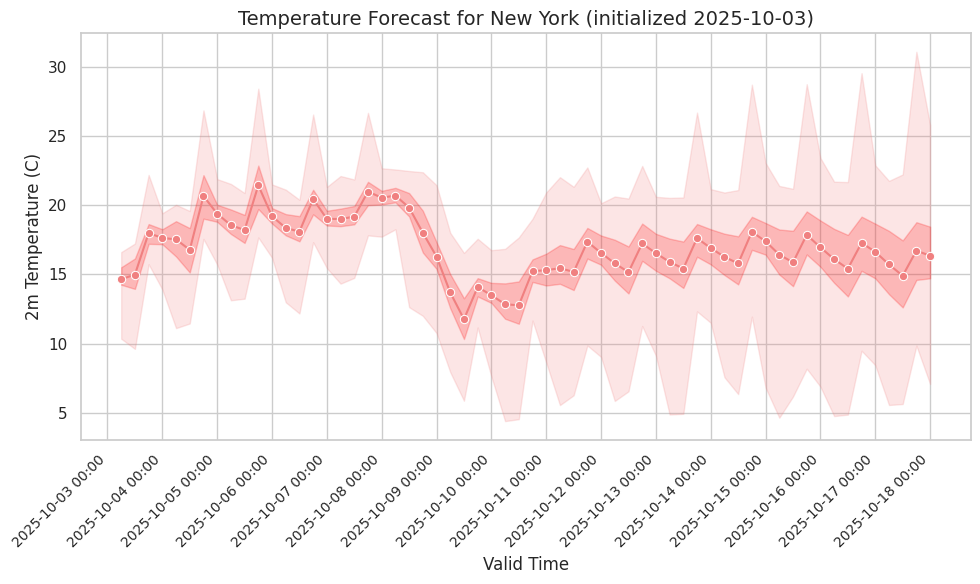

In [ ]:
# Extract the date from the first forecast_time
forecast_date = ny_temps['time'].iloc[0].strftime('%Y-%m-%d')

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Plot the data
# This will display a graph with a line representing the average temp, and
# error bars representing the min and max for each forecast time.
# The average temp is the average across all ensembles AND all polygons inside
# NYC.
# The average is implicitly calculated by the plotting library.

plt.figure(figsize=(10, 6))

# Avg with min and max band
def min_max_err(x):
  return (x.min(), x.max())
sns.lineplot(
    x=mdates.date2num(ny_temps['time'].dt.to_pydatetime()),
    y=ny_temps['2m_temperature'] - 273.15,
    errorbar=min_max_err,
    marker='o',
    linestyle='-',
    color='lightcoral'
)

# 50th percentile band
sns.lineplot(
    x=mdates.date2num(ny_temps['time'].dt.to_pydatetime()),
    y=ny_temps['2m_temperature'] - 273.15,
    errorbar=('pi', 50),
    marker='',
    linestyle='',
    color='red'
)

plt.xlabel('Valid Time', fontsize=12)
plt.ylabel('2m Temperature (C)', fontsize=12)
plt.title(f'Temperature Forecast for New York (initialized {forecast_date})', fontsize=14)

# Format the x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Show date and time
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks for each day
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()

## Deterministic forecasts

The forecasts produced by WeatherNext 2 consist of ensembles. To get a single deterministic forecast, you can average the values across all the ensembles, as in the following example:

### World - 10/03/2025 06:00 Hours
This query gets the values for all variables averaged over all ensemble members in a single forecast (specifically, with an init time of 2025-10-03 00:00 and valid time of 2025-10-03 06:00).

In contrast to the previous example, the average is calculated in the query itself, and not by processing the query output.

In [ ]:
%%bigquery world_avgs --project {project_id}
SELECT
  (SELECT AVG(`10m_u_component_of_wind`) FROM f.ensemble) AS avg_10m_u_component_of_wind,
  (SELECT AVG(`10m_v_component_of_wind`) FROM f.ensemble) AS avg_10m_v_component_of_wind,
  (SELECT AVG(`2m_temperature`) FROM f.ensemble) AS avg_2m_temperature,
  (SELECT AVG(mean_sea_level_pressure) FROM f.ensemble) AS avg_mean_sea_level_pressure,
  (SELECT AVG(sea_surface_temperature) FROM f.ensemble) AS avg_sea_surface_temperature,
  (SELECT AVG(total_precipitation_6hr) FROM f.ensemble) AS avg_total_precipitation_6hr,
  ST_X(ST_Centroid(t.geography_polygon)) AS longitude,
  ST_Y(ST_Centroid(t.geography_polygon)) AS latitude
FROM
  `dataset` AS t,
  t.forecast AS f
WHERE t.init_time = TIMESTAMP('2025-10-03 00:00:00 UTC')
  AND f.time = TIMESTAMP('2025-10-03 06:00:00 UTC');  -- Filter by the specified time

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
world_avgs

avg_10m_u_component_of_wind  avg_10m_v_component_of_wind  \
0                          -9.283851                     0.017072   
1                          -9.279111                     0.308080   
2                          -9.301127                     0.354110   
3                          -9.292366                    -0.316263   
4                          -9.288053                     0.066618   
...                              ...                          ...   
1038235                    -3.063569                    -4.716835   
1038236                    -0.140723                    -3.385393   
1038237                    -0.998155                    -3.724193   
1038238                     1.139198                    -1.300357   
1038239                     0.129361                    -2.692613   

         avg_2m_temperature  avg_mean_sea_level_pressure  \
0                266.406491                100860.463135   
1                266.412979                100861.717407   
2                266.409587                100862.111206   
3                266.394941                100859.582764   
4                266.404527                100861.085327   
...                     ...                          ...   
1038235          271.763196                 99787.232422   
1038236          271.123278                 99708.837891   
1038237          271.267728                 99754.514038   
1038238          267.729503                 99732.926270   
1038239          270.919194                 99672.308472   

         avg_sea_surface_temperature  avg_total_precipitation_6hr  longitude  \
0                         271.461266                     0.000111      -6.50   
1                         271.461189                     0.000111      -4.75   
2                         271.461251                     0.000111      -4.50   
3                         271.461365                     0.000111      -8.50   
4                         271.461228                     0.000111      -6.25   
...                              ...                          ...        ...   
1038235                   271.460484                     0.000012     159.75   
1038236                   271.458797                     0.000036     158.25   
1038237                   271.460297                     0.000015     159.00   
1038238                   271.481806                     0.000035     161.25   
1038239                   271.460352                     0.000081     157.75   

          latitude  
0        89.729167  
1        89.729167  
2        89.729167  
3        89.729167  
4        89.729167  
...            ...  
1038235 -62.749879  
1038236 -64.749860  
1038237 -63.999867  
1038238 -65.999846  
1038239 -65.249855  

[1038240 rows x 8 columns]


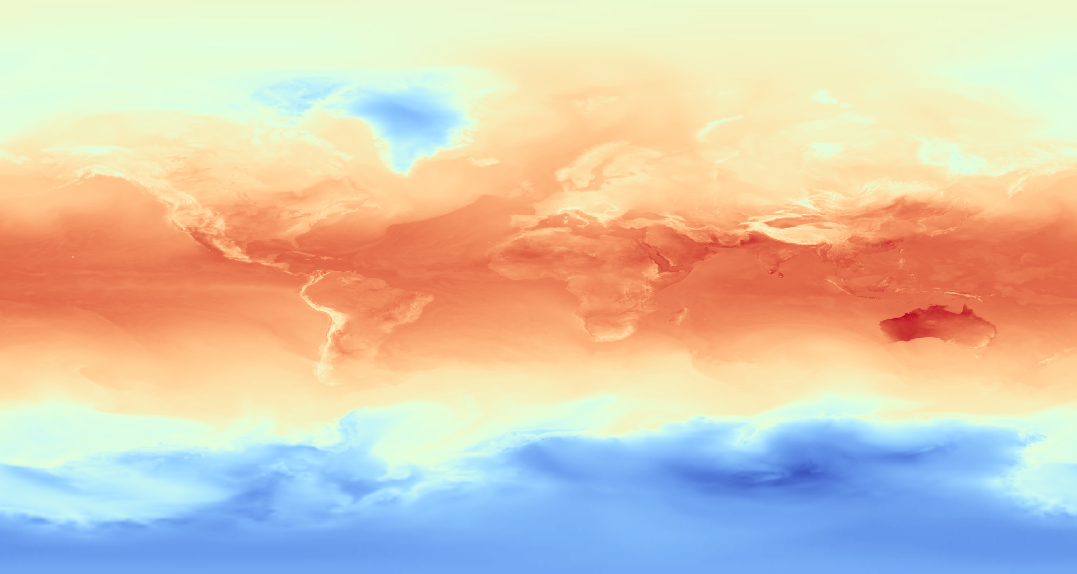

In [ ]:
# Map display options
variable = "avg_2m_temperature" # @param ["avg_2m_temperature", "avg_10m_u_component_of_wind", "avg_10m_v_component_of_wind", "avg_mean_sea_level_pressure", "avg_sea_surface_temperature", "avg_total_precipitation_6hr"]
palette = "coolwarm"  # @param ["coolwarm", "Spectral_r", "BuPu"]
pixelated = False  # @param {type:"boolean"}

# Convert points to an image
x = world_avgs['longitude']
y = world_avgs['latitude']
z = world_avgs[variable]

ny = len(np.unique(y)) // 250
nx = len(np.unique(x)) // 250

# Bin the data onto a regular grid
zi, xi, yi = np.histogram2d(x, y, bins=(nx, ny), weights=z)
counts, _, _ = np.histogram2d(x, y, bins=(nx, ny))

zi = zi / counts
zi = np.ma.masked_invalid(zi)

# Generate colors for the image
cm = matplotlib.colormaps[palette]
normed_data = (zi - zi.min()) / (zi.max() - zi.min())
# Rotate 90 deg counterclockwise so the image will be oriented correctly
# (Folium uses lat, lon instead of lon, lat).
z = cm(np.rot90(normed_data))

# Create a base map
m = folium.Map(location=[30, 0], zoom_start=2)

# Add temperature image
folium.raster_layers.ImageOverlay(
    image=z,
    bounds=[[yi.min(), xi.min()], [yi.max(), xi.max()]],
    mercator_project=True,
    pixelated=pixelated,
    opacity=0.5,
).add_to(m)

# Display the map
m